# Comparing Scores for tigge, deterministic, parametric, test-time dropout, categorical models

Todo
- run scripts for MC dropout
- in parametric, std values negative in 0.01% cases. ->make them zero.
- in categorical, 
    - instead of mean=sigma(xP), try sampling to find scores
    - see why quantile binning giving worse results than uniform
    - check if making first, last bin_edges uniform increases score.(minor thing.may skip)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xskillscore as xs
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *
from src.score import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
#limit_mem()

In [4]:
#if model was trained on mixed precision policy, loading on the same policy necessary? Yes. see verbose results of model.predict
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [5]:
# model_save_dir='/home/garg/data/WeatherBench/predictions_P/saved_models'
# datadir='/home/garg/data/WeatherBench/5.625deg'
# pred_save_dir='/home/garg/data/WeatherBench/predictions_P'
model_save_dir='/home/rasp/data/myWeatherBench/predictions_P/saved_models/'
datadir='/data/stephan/WeatherBench/5.625deg/'
pred_save_dir='/home/rasp/data/myWeatherBench/predictions_P/'

In [6]:
#Parameters
lead_time=72
member=2

In [7]:
!ls $pred_save_dir

001-resnet_d3_ztt_3d_dr0.0_m50.nc  011-resnet_d3_t_3d_cat_quant.nc
001-resnet_d3_ztt_3d_dr0.0.nc	   012-resnet_d3_t2m_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m50.nc  017-resnet_d3_ztt_3d_m50.nc
003-resnet_d3_ztt_3d_dr0.2.nc	   020-resnet_d3_tp_3d_dr0.0_m50.nc
004-resnet_d3_ztt_3d_dr0.5_m50.nc  020-resnet_d3_tp_3d_dr0.0.nc
004-resnet_d3_ztt_3d_dr0.5_m5.nc   021-resnet_d3_tp_3d_dr0.2_m50.nc
004-resnet_d3_ztt_3d_dr0.5.nc	   021-resnet_d3_tp_3d_dr0.2.nc
005-resnet_d3_ztt_3d_param.nc	   022-resnet_d3_tp_3d_dr0.5_m50.nc
006-resnet_d3_z_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5_m5.nc
0078resnet_d3_t2m_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5.nc
007-resnet_d3_t_3d_cat.nc	   054-resnet_d3_tp_3d_m50.nc
009-resnet_d3_tp_3d_cat.nc	   saved_models
010-resnet_d3_z_3d_cat_quant.nc


## Data

In [8]:
!ls {datadir}

24hr_precipitation    geopotential	   temperature_850
2m_temperature	      geopotential_500	   toa_incident_solar_radiation
2m_temperature_daily  potential_vorticity  total_precipitation
6hr_precipitation     specific_humidity    u_component_of_wind
constants	      temperature	   v_component_of_wind


In [9]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
t2m_valid = xr.open_mfdataset(f'{datadir}/2m_temperature/*.nc',combine='by_coords')
tp_valid=xr.open_mfdataset(f'{datadir}/6hr_precipitation/*.nc',combine='by_coords')

# SR: Not necessary because we never look at other levels
ztt_valid=xr.merge([z500_valid,t850_valid, t2m_valid])  #.rename({'z':'z_500', 't':'t_850'})
valid=xr.merge([ztt_valid, tp_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350640)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(341880, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(341880, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [56]:
# dr=0.1 missing.
# exp_id='001-resnet_d3_ztt_3d_dr0.0'
# dr00_ztt_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

#exp_id='002-resnet_d3_ztt_3d_dr0.1'
#dr01_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='003-resnet_d3_ztt_3d_dr0.2'
# dr02_ztt_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}_m{member}.nc').rename({'z':'z_500','t':'t_850'})

# exp_id='004-resnet_d3_ztt_3d_dr0.5'
# dr05_ztt_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='005-resnet_d3_ztt_3d_param'
# param_ztt_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

exp_id='006-resnet_d3_z_3d_cat'
cat_z_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

exp_id='007-resnet_d3_t_3d_cat'
cat_t_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')
#t2m missing, p missing.
# exp_id='010-resnet_d3_z_3d_cat_quant'
# cat_quant_z_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='011-resnet_d3_t_3d_cat_quant'
# cat_quant_t_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='020-resnet_d3_tp_3d_dr0.0'
# dr00_tp_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

# exp_id='021-resnet_d3_tp_3d_dr0.2'
# dr02_tp_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}_m{member}.nc')

# exp_id='022-resnet_d3_tp_3d_dr0.5'
# dr05_tp_preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [11]:
#param_ztt_preds

In [12]:
#dr02_ztt_preds, dr02_tp_preds

In [13]:
#cat_z_preds
#cat_quant_z_preds.z

## TIGGE - TODO

In [217]:
tigge_dir = '/mnt/netdisk1/stephan/WeatherBench/tigge/5.625deg/'

In [220]:
tigge_z = xr.open_mfdataset(f'{tigge_dir}geopotential_500_ens/*nc')
tigge_t = xr.open_mfdataset(f'{tigge_dir}temperature_850_ens/*nc')
tigge_t2m = xr.open_mfdataset(f'{tigge_dir}2m_temperature_ens/*nc')
tigge_tp = xr.open_mfdataset(f'{tigge_dir}total_precipitation_ens/*nc')

In [221]:
# Covert to ERA convention
tigge_z *= 9.806

In [227]:
# TODO Precipitation

In [233]:
tigge = xr.merge([tigge_z, tigge_t, tigge_t2m], compat="override")

In [234]:
tigge = tigge.rename({'number': 'member', 'gh':'z'})
tigge = tigge.sel(step='3 days')
tigge['time'] = tigge['valid_time']

In [247]:
tigge = tigge.sel(time=slice('2017', '2018'))

In [237]:
tigge.load()

<xarray.Dataset>
Dimensions:            (lat: 32, lon: 64, member: 50, time: 1460)
Coordinates:
    step               timedelta64[ns] 3 days
  * time               (time) datetime64[ns] 2017-01-04 ... 2019-01-03T12:00:00
  * lat                (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon                (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * member             (member) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    isobaricInhPa      int64 500
    valid_time         (time) datetime64[ns] 2017-01-04 ... 2019-01-03T12:00:00
    heightAboveGround  int64 2
Data variables:
    z                  (member, time, lat, lon) float32 51355.71 ... 49082.082
    t                  (member, time, lat, lon) float32 258.87042 ... 253.72827
    t2m                (member, time, lat, lon) float32 246.63593 ... 248.36401

### RMSE of ensemble mean

In [248]:
tigge_rmse = compute_weighted_rmse(tigge.mean('member'), valid).load()

/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [249]:
tigge_rmse

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    heightAboveGround  int64 2
    isobaricInhPa      int64 500
    step               timedelta64[ns] 3 days
Data variables:
    z                  float64 144.8
    t                  float64 1.201
    t2m                float64 1.257

In [250]:
tigge_rmse.to_netcdf('/tmp/tigge_rmse.nc')

### Spread-skill

In [251]:
tigge_spreadskill=compute_weighted_meanspread(tigge)/tigge_rmse
tigge_spreadskill

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    step               timedelta64[ns] 3 days
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
Data variables:
    z                  float64 1.051
    t                  float64 0.9288
    t2m                float64 0.6881

In [252]:
tigge_spreadskill.to_netcdf('/tmp/tigge_spreadskill.nc')

### CRPS

In [254]:
tigge_crps=compute_weighted_crps(tigge, valid[['z', 't', 't2m']].sel(time=tigge.time))
tigge_crps.load()

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    step               timedelta64[ns] 3 days
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
Data variables:
    z                  float64 65.6
    t                  float64 0.5994
    t2m                float64 0.5755

In [255]:
tigge_crps.to_netcdf('/tmp/tigge_crps.load.nc')

### Rank histogram - TODO

## Monte-carlo dropout

In [114]:
!ls ../nn_configs/C/017*

../nn_configs/C/017-resnet_d3_ztt_3d.yml


In [115]:
pred_save_dir='/home/rasp/data/myWeatherBench/predictions_'

mc_exp_ids_ztt = [
    'P/001-resnet_d3_ztt_3d_dr0.0',
    'C/017-resnet_d3_ztt_3d',
    'P/003-resnet_d3_ztt_3d_dr0.2',
    'P/004-resnet_d3_ztt_3d_dr0.5',
]

mc_exp_ids_tp = [
    'P/020-resnet_d3_tp_3d_dr0.0',
    'C/054-resnet_d3_tp_3d',
    'P/021-resnet_d3_tp_3d_dr0.2',
    'P/022-resnet_d3_tp_3d_dr0.5',
]

### Load and evaluate no-dropout predictions

In [116]:
rmses, maes = [], []
for i, dr in tqdm(enumerate([0, 0.1, 0.2, 0.5])):
    preds_ztt = xr.open_dataset(pred_save_dir+mc_exp_ids_ztt[i]+'.nc')
    preds_tp = xr.open_dataset(pred_save_dir+mc_exp_ids_tp[i]+'.nc')
    preds = xr.merge([preds_ztt, preds_tp]).isel(time=slice(0, None, 12))
    rmse = compute_weighted_rmse(preds, valid).load()
    rmses.append(rmse)
    mae = compute_weighted_mae(preds, valid).load()
    maes.append(mae)

0it [00:09, ?it/s]


KeyboardInterrupt: 

In [ ]:
rmses = xr.concat(rmses, dim=[0, 0.1, 0.2, 0.5])
maes = xr.concat(maes, dim=[0, 0.1, 0.2, 0.5])
rmses

In [84]:
# !mkdir tmp

In [82]:
rmses.to_netcdf('tmp/rmse_dr_det.nc')
maes.to_netcdf('tmp/mae_dr_det.nc')

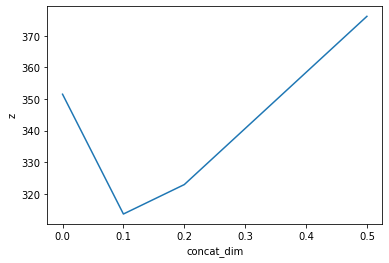

In [83]:
rmses.z.plot();

### Create 50 member dropout predictions

SR: Only predicting every 12th time step. Makes very little difference for score and is 12 times faster. You should be able to do this on PC as well. For me this takes around 4 minutes.

Note: Manually change P to C for 0.1 exps.

In [46]:
for e in mc_exp_ids_ztt:
    s = f'python create_dropout_ensemble.py  50  ../nn_configs/{e}.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --data_subsample 12'
    print(s)

python create_dropout_ensemble.py  50  ../nn_configs/P/001-resnet_d3_ztt_3d_dr0.0.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/C/017-resnet_d3_ztt_3d.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/P/003-resnet_d3_ztt_3d_dr0.2.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/P/004-resnet_d3_ztt_3d_dr0.5.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 1 --

In [49]:
for e in mc_exp_ids_tp:
    s = f'python create_dropout_ensemble.py  50  ../nn_configs/{e}.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data_subsample 12'
    print(s)

python create_dropout_ensemble.py  50  ../nn_configs/P/020-resnet_d3_tp_3d_dr0.0.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/C/054-resnet_d3_tp_3d.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/P/021-resnet_d3_tp_3d_dr0.2.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data_subsample 12
python create_dropout_ensemble.py  50  ../nn_configs/P/022-resnet_d3_tp_3d_dr0.5.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 7 --data

### Compute RMSE of ensemble mean and spread/skill and CRPS

In [119]:
members = 50

In [183]:
mc_exp_ids_ztt = [
    'P/001-resnet_d3_ztt_3d_dr0.0',
    'P/017-resnet_d3_ztt_3d',
    'P/003-resnet_d3_ztt_3d_dr0.2',
    'P/004-resnet_d3_ztt_3d_dr0.5',
]

mc_exp_ids_tp = [
    'P/020-resnet_d3_tp_3d_dr0.0',
    'P/054-resnet_d3_tp_3d',
    'P/021-resnet_d3_tp_3d_dr0.2',
    'P/022-resnet_d3_tp_3d_dr0.5',
]

In [100]:
rmses, maes, crpss, spread_skills = [], [], [], []
for i, dr in tqdm(enumerate([0, 0.1, 0.2, 0.5])):
    preds_ztt = xr.open_dataset(pred_save_dir+mc_exp_ids_ztt[i]+f'_m{members}.nc')
    preds_tp = xr.open_dataset(pred_save_dir+mc_exp_ids_tp[i]+f'_m{members}.nc')
    preds = xr.merge([preds_ztt, preds_tp])
    ens_mean = preds.mean('member')
    rmse = compute_weighted_rmse(ens_mean, valid).load()
    mae = compute_weighted_mae(ens_mean, valid).load()
    crps = compute_weighted_crps(preds, valid).load()
    spread = compute_weighted_meanspread(preds).load()
    rmses.append(rmse)
    maes.append(mae)
    crpss.append(crps)
    spread_skills.append(spread / rmse)



0it [00:00, ?it/s]

1it [00:22, 22.13s/it]

2it [00:45, 22.46s/it]

3it [01:09, 22.86s/it]

4it [01:33, 23.26s/it]


In [101]:
rmses = xr.concat(rmses, dim=[0, 0.1, 0.2, 0.5])
maes = xr.concat(maes, dim=[0, 0.1, 0.2, 0.5])
crpss = xr.concat(crpss, dim=[0, 0.1, 0.2, 0.5])
spread_skills = xr.concat(spread_skills, dim=[0, 0.1, 0.2, 0.5])

In [102]:
rmses.to_netcdf('tmp/rmse_dr_mean.nc')
maes.to_netcdf('tmp/mae_dr_mean.nc')
crpss.to_netcdf('tmp/crps_dr.nc')
spread_skills.to_netcdf('./spread_skills_dr.nc')

In [257]:
rmses = xr.open_dataset('tmp/rmse_dr_mean.nc')
maes = xr.open_dataset('tmp/mae_dr_mean.nc')
crpss = xr.open_dataset('tmp/crps_dr.nc')
spread_skills = xr.open_dataset('./spread_skills_dr.nc')

In [276]:
crpss[['z', 't', 't2m', 'tp']].isel(concat_dim=3).load()

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    concat_dim  float64 0.5
Data variables:
    z           float64 243.6
    t           float64 1.504
    t2m         float64 1.12
    tp          float64 0.0006331

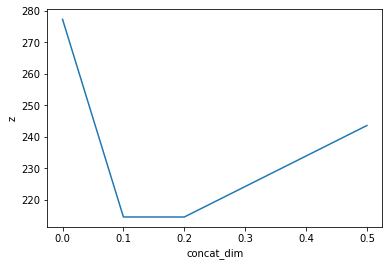

In [103]:
crpss.z.plot()

### Rank histogram - TODO

In [117]:
from ranky import rankz

In [187]:
ranks = {}
for i, dr in tqdm(enumerate([0.1, 0.2, 0.5])):
    ranks[dr] = {}
    print(dr)
    preds_ztt = xr.open_dataset(pred_save_dir+mc_exp_ids_ztt[i+1]+f'_m{members}.nc')
    preds_tp = xr.open_dataset(pred_save_dir+mc_exp_ids_tp[i+1]+f'_m{members}.nc')
    preds = xr.merge([preds_ztt, preds_tp])
    for v in preds:
        print(v)
        time = preds.time[:1]
        p = preds[v].sel(time=time)
        o = valid[v].sel(time=time).load()
        mask = np.ones(o.shape)
        rank = rankz(o.values, p.values, mask)
        with open(f'tmp/rank_dr_{dr}_{v}.pkl', 'wb') as f:
            pickle.dump(rank, f)
        ranks[dr][v] = rank

0it [00:00, ?it/s]

0.1
t2m
z
t
tp


1it [00:04,  4.99s/it]

0.2
z
t
t2m
tp


2it [00:09,  4.94s/it]

0.5
t2m
z
t


3it [00:16,  5.43s/it]

tp


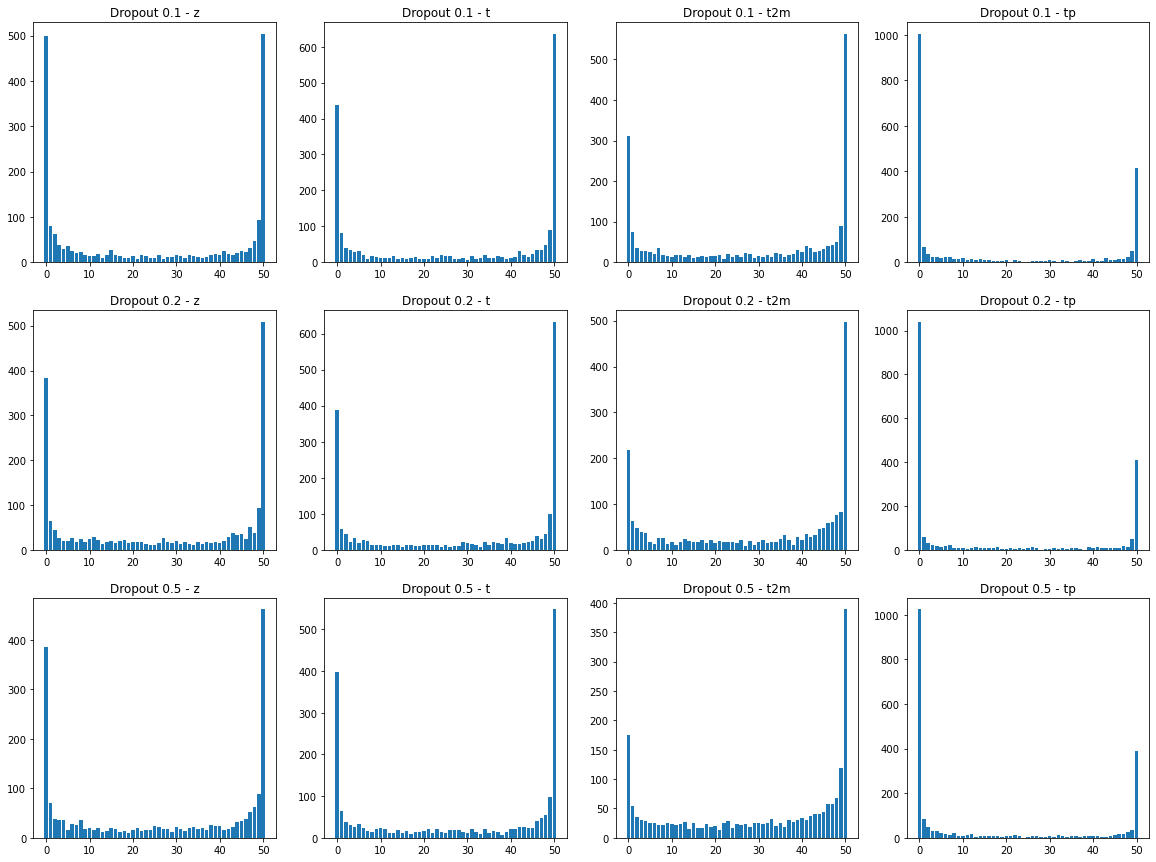

In [192]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, dr in enumerate([0.1, 0.2, 0.5]):
    for j, v in enumerate(['z', 't', 't2m', 'tp']):
        r = ranks[dr][v]
        axs[i, j].bar(np.arange(51), r[0])
        axs[i, j].set_title(f'Dropout {dr} - {v}')

In [169]:
%time rank_z = rankz(o.values, p.values, mask)

CPU times: user 1min 53s, sys: 1.3 s, total: 1min 54s
Wall time: 1min 54s


In [161]:
%time rankz(o.values, p.values, mask)

CPU times: user 1.5 s, sys: 19.2 ms, total: 1.52 s
Wall time: 1.55 s


(array([8147, 1729, 1072,  871,  664,  572,  550,  474,  462,  479,  416,
         434,  382,  337,  359,  363,  330,  345,  289,  333,  274,  315,
         300,  285,  274,  292,  324,  326,  340,  300,  303,  314,  322,
         320,  310,  340,  344,  349,  377,  384,  391,  426,  451,  500,
         518,  604,  651,  855, 1131, 1803, 8629]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5]))

### Old

In [12]:
??load_args

In [15]:
ds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_P//004-resnet_d3_ztt_3d_dr0.5_dr_0.1_m50.nc')

In [16]:
ds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 2, time: 1454)
Coordinates:
  * member   (member) int64 0 1
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (member, time, lat, lon) float64 ...
    t2m      (member, time, lat, lon) float64 ...
    t        (member, time, lat, lon) float64 ...

In [14]:
#Ask- Please run for 100. (for each- ztt, tp, for each- dr 0.1,0.2, dr 0.5)
member=2

# exp_id_path='/home/garg/WeatherBench/nn_configs/P/004-resnet_d3_ztt_3d_dr0.5.yml'
exp_id_path='../nn_configs/P/004-resnet_d3_ztt_3d_dr0.5.yml'
args=load_args(exp_id_path)
args['model_save_dir']=model_save_dir
args['datadir']=datadir
args['pred_save_dir']=pred_save_dir

print('python create_dropout_ensemble.py ',member," "+exp_id_path+" "+datadir+" "+model_save_dir+" "+pred_save_dir)

#For precipitation, no_mean=True
#!python create_dropout_ensemble.py 2 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} no_mean=True old_const=False

python create_dropout_ensemble.py  2  ../nn_configs/P/004-resnet_d3_ztt_3d_dr0.5.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/


In [23]:
# preds=xr.open_dataset(f'{pred_save_dir}/{args["exp_id"]}_m2.nc')
# preds

In [20]:
preds=xr.merge([dr02_ztt_preds, dr02_tp_preds])
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 2, time: 17436)
Coordinates:
  * member   (member) int64 0 1
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (member, time, lat, lon) float64 ...
    t_850    (member, time, lat, lon) float64 ...
    z_500    (member, time, lat, lon) float64 ...
    tp       (member, time, lat, lon) float64 ...

In [21]:
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [37]:
#RMSE
ens_mean=preds.mean('member')
dr02_rmse=compute_weighted_rmse(ens_mean,valid)
dr02_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.665
    t_850    float64 1.928
    z_500    float64 341.7
    tp       float64 0.002167

In [38]:
#Spread-Skill
dr02_spread=compute_weighted_meanspread(preds)
dr02_spreadskill=dr02_spread/dr02_rmse
dr02_spreadskill.load() #pretty bad

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.298
    t_850    float64 0.257
    z_500    float64 0.3045
    tp       float64 0.08413

In [40]:
#CRPS
dr02_crps=compute_weighted_crps(preds, valid.sel(time=preds.time))
dr02_crps.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 191.8
    t_850    float64 1.222
    t2m      float64 0.9523
    tp       float64 0.0006109

In [26]:
#Rank Histogram
pred=preds
pred=pred.isel(time=slice(0,20))#or slice members. #Ask- Run Full. Only a subset possible. too slow.
obs=valid.sel(time=preds.time)
obs = obs.chunk({'time': 500})
pred=pred.chunk({'time':500})
#Ques: doesnt help much. still unable to run rank-histogram on full data due to memory error.

from ranky import rankz

mask=np.ones(obs.z_500.values.shape) #useless. #masked where 0/false.
result_z_500 = rankz(obs.z_500.values, preds.z_500.values, mask)
result_t_850 = rankz(obs.t_850.values, preds.z_500.values, mask)
result_t2m = rankz(obs.t2m.values, preds.z_500.values, mask)
result_tp = rankz(obs.tp.values, preds.z_500.values, mask)

KeyboardInterrupt: 

In [ ]:
fig, axs=plt.subplots(2,2)
axs[0,0].bar(range(1,pred.z_500.values.shape[0]+2), result_z[0])
axs[0,1].bar(range(1,pred.t_850.values.shape[0]+2), result_t[0])
axs[1,0].bar(range(1,pred.t2m.values.shape[0]+2), result_t2m[0])
axs[1,1].bar(range(1,pred.tp.values.shape[0]+2), result_tp[0])

## Parametric

In [193]:
preds_ztt = xr.open_dataset(f'{pred_save_dir}P/005.1-resnet_d3_ztt_3d_param.nc')

In [194]:
preds_ztt_mean=preds_ztt[['z-mean','t-mean','t2m-mean']].rename({'z-mean':'z','t-mean':'t','t2m-mean':'t2m'})
preds_ztt_std=preds_ztt[['z-std','t-std','t2m-std']].rename({'z-std':'z','t-std':'t','t2m-std':'t2m'})

In [195]:
preds_ztt_std = preds_ztt_std.where(preds_ztt_std>0, 1e-7)  # To avoid division by zero in CRPS

### RMSE of ensemble mean

In [126]:
rmse = compute_weighted_rmse(preds_ztt_mean, valid).compute()
rmse

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 315.3
    t        float64 1.818
    t2m      float64 1.549

### Spread skill

In [127]:
var = preds_ztt_std**2

In [128]:
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()

In [129]:
spread= np.sqrt((var*weights_lat).mean())

In [130]:
spread_skill = spread / rmse

In [131]:
spread_skill

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 0.8716
    t        float64 0.9208
    t2m      float64 0.9462

### CRPS

In [132]:
def compute_weighted_crps_gaussian(obs, mean, std,mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(obs.lat)).values
    weights_lat /= weights_lat.mean()
    crps = xs.crps_gaussian(obs,mean,std)
    crps = (crps * weights_lat[: , None, None]).mean(mean_dims)
    return crps

In [133]:
compute_weighted_crps_gaussian(valid.isel(time=slice(0, None, 12))[['z', 't', 't2m']], preds_ztt_mean, preds_ztt_std).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 142.7
    t        float64 0.9016
    t2m      float64 0.7037

### Rank histogram

In [196]:
members

50

In [197]:
preds_ztt_mean.z.shape

(17388, 32, 64)

In [204]:
members=50

In [208]:
das = []
for v in preds_ztt_mean:
    da = xr.DataArray(
        np.random.normal(
            preds_ztt_mean[v].values, 
            preds_ztt_std[v].values,
            size=(members, *preds_ztt_mean[v].shape)
        ),
        coords={
            'member': np.arange(members),
            'time': preds_ztt_mean.time,
            'lat': preds_ztt_mean.lat, 
            'lon': preds_ztt_mean.lon,}, 
        dims=['member','time','lat', 'lon'],
        name=v
    )
    das.append(da)
preds_ztt_ens = xr.merge(das)

In [209]:
ranks = {}
for v in preds_ztt_ens:
    print(v)
    time = preds_ztt_ens.time[:1]
    p = preds_ztt_ens[v].sel(time=time)
    o = valid[v].sel(time=time).load()
    mask = np.ones(o.shape)
    rank = rankz(o.values, p.values, mask)
    with open(f'tmp/rank_param_{v}.pkl', 'wb') as f:
        pickle.dump(rank, f)
    ranks[v] = rank

z
t
t2m


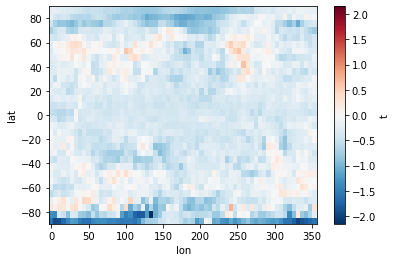

In [216]:
(preds_ztt_mean.t - valid.t).isel(time=slice(0, None, 100)).mean('time').plot()

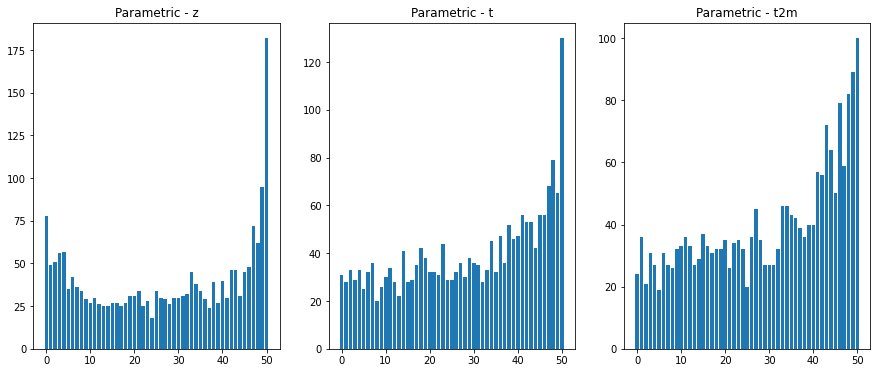

In [210]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for j, v in enumerate(['z', 't', 't2m']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Parametric - {v}')

### old

In [14]:
param_ztt_preds=param_ztt_preds.rename({'z-mean':'z_mean','z-std':'z_std', 't-mean':'t_mean', 't-std':'t_std','t2m-mean':'t2m_mean','t2m-std':'t2m_std'})
param_ztt_preds

<xarray.Dataset>
Dimensions:   (lat: 32, lon: 64, time: 17388)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-29T23:00:00
  * lat       (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon       (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m_std   (time, lat, lon) float64 ...
    z_mean    (time, lat, lon) float64 ...
    z_std     (time, lat, lon) float64 ...
    t_std     (time, lat, lon) float64 ...
    t2m_mean  (time, lat, lon) float64 ...
    t_mean    (time, lat, lon) float64 ...

In [16]:
#Ask: 0.014% values of std are -ve. Changing to absolute for now.
a=param_ztt_preds.z_std.where(param_ztt_preds.z_std<0).values
print(np.count_nonzero(~np.isnan(a))*100/a.size)
#change to zero.
param_ztt_preds['z_std']=param_ztt_preds.z_std.where(param_ztt_preds.z_std>0,0)
param_ztt_preds['t_std']=param_ztt_preds.t_std.where(param_ztt_preds.t_std>0,0)
param_ztt_preds['t2m_std']=param_ztt_preds.t2m_std.where(param_ztt_preds.t2m_std>0,0)

0.01453779636099609


In [18]:
param_ztt_preds_mean=param_ztt_preds[['z_mean','t_mean','t2m_mean']].rename({'z_mean':'z_500','t_mean':'t_850','t2m_mean':'t2m'})
param_ztt_preds_std=param_ztt_preds[['z_std','t_std','t2m_std']].rename({'z_std':'z_500','t_std':'t_850','t2m_std':'t2m'})

In [19]:
print(param_ztt_preds_mean.z_500.isel(lat=0,lon=0,time=0).values, param_ztt_preds_mean.t_850.isel(lat=0,lon=0,time=0).values, param_ztt_preds_mean.t2m.isel(lat=0,lon=0,time=0).values)
print(param_ztt_preds_std.z_500.isel(lat=0,lon=0,time=0).values, param_ztt_preds_std.t_850.isel(lat=0,lon=0,time=0).values, param_ztt_preds_std.t2m.isel(lat=0,lon=0,time=0).values)

51156.67786528251 257.3167883721469 248.26674222538108
319.78635102035287 1.1886433908207181 1.8425003027575264


In [20]:
#RMSE
param_ztt_rmse=compute_weighted_rmse(param_ztt_preds_mean, ztt_valid)
param_ztt_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 341.2
    t_850    float64 1.892
    t2m      float64 1.598

In [21]:
#Ask-Spread-skill. !Weighting is done after square root.
var1=param_ztt_preds_std
var1=param_ztt_preds_std*param_ztt_preds_std
weights_lat = np.cos(np.deg2rad(var1.lat))
weights_lat /= weights_lat.mean()
param_ztt_spread= np.sqrt((var1*weights_lat).mean())
param_ztt_spread

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 212.9
    t_850    float64 1.471
    t2m      float64 1.306

In [22]:
#spread-skill
param_ztt_spreadskill=param_ztt_spread/param_ztt_rmse
param_ztt_spreadskill

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 0.624
    t_850    float64 0.7778
    t2m      float64 0.8176

In [23]:
def compute_weighted_crps_gaussian(obs, mean, std,mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(obs.lat)).values
    weights_lat /= weights_lat.mean()
    crps = xs.crps_gaussian(obs,mean,std)
    crps = (crps * weights_lat[None, : , None]).mean(mean_dims)
    return crps

In [24]:
#Ask-CRPS. don't know where division by zero. Also scores look worse (another network had 134 for z)
param_ztt_crps=compute_weighted_crps_gaussian(ztt_valid.sel(time=param_ztt_preds.time), 
                                    param_ztt_preds_mean, param_ztt_preds_std)
param_ztt_crps.load()

/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/properscoring/_crps.py:66: RuntimeWarning: divide by zero encountered in true_divide
  sx = (x - mu) / sig
/home/garg/miniconda3/envs/weatherbench/lib/python3.6/site-packages/properscoring/_crps.py:72: RuntimeWarning: invalid value encountered in multiply
  crps = sig * (sx * (2 * cdf - 1) + 2 * pdf - pi_inv)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 151.2
    t_850    float64 0.9169
    t2m      float64 0.6883

In [25]:
#Rank Histogram
#members=10
#Taking random samples from a gaussian and making an ensemble (Will have to use another method for precipitation)

z_500=xr.DataArray(np.random.normal(param_ztt_preds.z_mean.values, param_ztt_preds.z_std.values,
                                    size=(member,param_ztt_preds.z_mean.shape[0],
                                         param_ztt_preds.z_mean.shape[1],
                                         param_ztt_preds.z_mean.shape[2])),
                     coords={'member': np.arange(member),
                             'time': param_ztt_preds.time,
                             'lat': param_ztt_preds.lat, 'lon': param_ztt_preds.lon,}, 
                     dims=['member','time','lat', 'lon'])

t_850=xr.DataArray(np.random.normal(param_ztt_preds.t_mean.values, param_ztt_preds.t_std.values,
                                    size=(member,param_ztt_preds.t_mean.shape[0],
                                         param_ztt_preds.t_mean.shape[1],
                                         param_ztt_preds.t_mean.shape[2])),
                     coords={'member': np.arange(member),
                             'time': param_ztt_preds.time,
                             'lat': param_ztt_preds.lat, 'lon': param_ztt_preds.lon,}, 
                     dims=['member','time','lat', 'lon'])

t2m=xr.DataArray(np.random.normal(param_ztt_preds.t2m_mean.values, param_ztt_preds.t2m_std.values,
                                    size=(member,param_ztt_preds.t2m_mean.shape[0],
                                         param_ztt_preds.t2m_mean.shape[1],
                                         param_ztt_preds.t2m_mean.shape[2])),
                     coords={'member': np.arange(member),
                             'time': param_ztt_preds.time,
                             'lat': param_ztt_preds.lat, 'lon': param_ztt_preds.lon,}, 
                     dims=['member','time','lat', 'lon'])



preds_new=xr.Dataset()
preds_new['z_500']=z_500
preds_new['t_850']=t_850
preds_new['t2m']=t2m
preds_new

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 2, time: 17388)
Coordinates:
  * member   (member) int64 0 1
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-29T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 5.079e+04 5.126e+04 ... 4.931e+04
    t_850    (member, time, lat, lon) float64 257.3 258.1 255.5 ... 261.8 255.3
    t2m      (member, time, lat, lon) float64 250.1 249.1 249.4 ... 252.2 252.6

In [26]:
#Rank Histogram
pred=preds_new
pred=pred.isel(time=slice(0,20))#or slice members. #Ask- Run Full. Only a subset possible. too slow.
obs=ztt_valid.sel(time=pred.time)
obs = obs.chunk({'time': 500})
pred=pred.chunk({'time':500})
#Ques: doesnt help much. still unable to run rank-histogram on full data due to memory error.

from ranky import rankz

#for z_500
mask=np.ones(obs.z_500.values.shape) #useless. #masked where 0/false.
result_z = rankz(obs.z_500.values, pred.z_500.values, mask)
result_t = rankz(obs.t_850.values, pred.t_850.values, mask)
result_t2m = rankz(obs.t2m.values, pred.t2m.values, mask)
#result_tp = rankz(obs.tp.values, pred.tp.values, mask)

<BarContainer object of 3 artists>

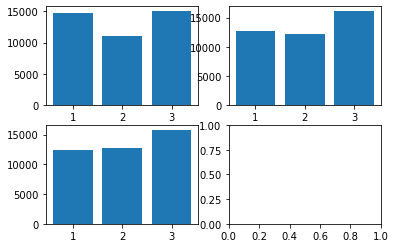

In [38]:
fig, axs=plt.subplots(2,2)
axs[0,0].bar(range(1,pred.z_500.values.shape[0]+2), result_z[0])
axs[0,1].bar(range(1,pred.t_850.values.shape[0]+2), result_t[0])
axs[1,0].bar(range(1,pred.t2m.values.shape[0]+2), result_t2m[0])
#axs[1,1].bar(range(1,pred.tp.values.shape[0]+2), result_tp[0])




## Categorical

In [12]:
!ls {pred_save_dir}P

001-resnet_d3_ztt_3d_dr0.0_m50.nc  011-resnet_d3_t_3d_cat_quant.nc
001-resnet_d3_ztt_3d_dr0.0.nc	   012-resnet_d3_t2m_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m50.nc  017-resnet_d3_ztt_3d_m50.nc
003-resnet_d3_ztt_3d_dr0.2.nc	   020-resnet_d3_tp_3d_dr0.0_m50.nc
004-resnet_d3_ztt_3d_dr0.5_m50.nc  020-resnet_d3_tp_3d_dr0.0.nc
004-resnet_d3_ztt_3d_dr0.5_m5.nc   021-resnet_d3_tp_3d_dr0.2_m50.nc
004-resnet_d3_ztt_3d_dr0.5.nc	   021-resnet_d3_tp_3d_dr0.2.nc
005-resnet_d3_ztt_3d_param.nc	   022-resnet_d3_tp_3d_dr0.5_m50.nc
006-resnet_d3_z_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5_m5.nc
0078resnet_d3_t2m_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5.nc
007-resnet_d3_t_3d_cat.nc	   054-resnet_d3_tp_3d_m50.nc
009-resnet_d3_tp_3d_cat.nc	   saved_models
010-resnet_d3_z_3d_cat_quant.nc


In [52]:
valid_diff = (valid.shift() -  valid.shift(time=lead_time)).isel(time=slice(0, None, 12))

In [53]:
valid_diff['tp'] = valid['tp']

In [54]:
valid_diff

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 29220)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(28490, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(28490, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>

In [308]:
preds_cat = xr.merge([
    xr.open_dataset(f'{pred_save_dir}P/006.1-resnet_d3_z_3d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}P/007-resnet_d3_t_3d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}P/0078resnet_d3_t2m_3d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}P/009-resnet_d3_tp_3d_cat.nc'),
]).isel(time=slice(0, None, 12))

In [278]:
preds_cat

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 1453)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z        (time, lat, lon, bin) float32 ...
    t        (time, lat, lon, bin) float32 ...
    t2m      (time, lat, lon, bin) float32 ...
    tp       (time, lat, lon, bin) float32 ...

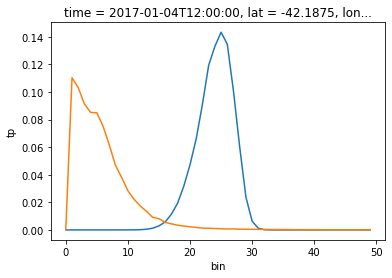

In [279]:
time = '2017-01-04T12:00:00'
preds_cat.z.sel(time=time).isel(lat=8, lon=16).plot()
preds_cat.tp.sel(time=time).isel(lat=8, lon=16).plot()

In [280]:
def log_retrans(x, e):
    return np.exp(x + np.log(e)) - e

In [281]:
# Adjust bin edges and mid_points
for v in ['z', 't', 't2m']:
    preds_cat[v].bin_edges[0] = valid_diff[v].min().values
    preds_cat[v].bin_edges[-1] = valid_diff[v].max().values
    preds_cat[v].mid_points[:] = (preds_cat[v].bin_edges[1:] +  preds_cat[v].bin_edges[:-1])/2

v='tp'
preds_cat[v].bin_edges[:] = log_retrans(preds_cat[v].bin_edges, 0.001)
preds_cat[v].bin_edges[0] = 0
preds_cat[v].bin_edges[-1] = valid[v].max().values
preds_cat[v].mid_points[:] = (preds_cat[v].bin_edges[1:] +  preds_cat[v].bin_edges[:-1])/2
preds_cat[v].mid_points[0] = 0

In [288]:
preds_cat['tp'].bin_edges

array([0.00000000e+00, 2.98909758e-05, 6.06754220e-05, 9.23800454e-05,
       1.25032351e-04, 1.58660666e-04, 1.93294164e-04, 2.28962890e-04,
       2.65697790e-04, 3.03530732e-04, 3.42494538e-04, 3.82623010e-04,
       4.23950961e-04, 4.66514244e-04, 5.10349786e-04, 5.55495615e-04,
       6.01990897e-04, 6.49875968e-04, 6.99192371e-04, 7.49982889e-04,
       8.02291585e-04, 8.56163839e-04, 9.11646387e-04, 9.68787363e-04,
       1.02763634e-03, 1.08824437e-03, 1.15066403e-03, 1.21494948e-03,
       1.28115648e-03, 1.34934247e-03, 1.41956661e-03, 1.49188982e-03,
       1.56637483e-03, 1.64308628e-03, 1.72209071e-03, 1.80345666e-03,
       1.88725471e-03, 1.97355757e-03, 2.06244011e-03, 2.15397943e-03,
       2.24825496e-03, 2.34534847e-03, 2.44534420e-03, 2.54832890e-03,
       2.65439191e-03, 2.76362525e-03, 2.87612368e-03, 2.99198480e-03,
       3.11130912e-03, 3.23420016e-03, 1.97932243e-01])

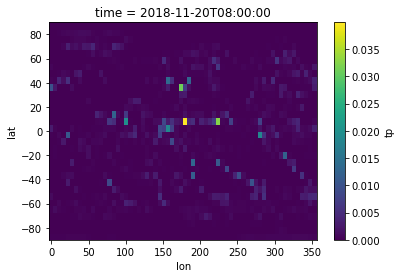

In [297]:
valid.tp.isel(time=-1000).plot()

In [298]:
log_trans(0.05, 0.001)

3.9318256327243257

#### Interlude: Did I chose the wrong bind edges for tp?

In [106]:
tp = valid['tp'].copy(True).isel(time=slice(0, None, 120)).load()

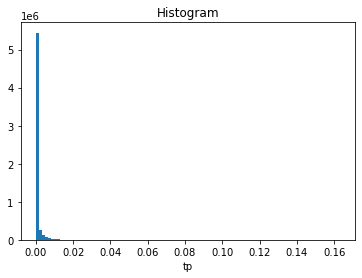

In [108]:
tp.plot.hist(bins=100);

In [109]:
def log_trans(x, e):
    return np.log(x + e) - np.log(e)

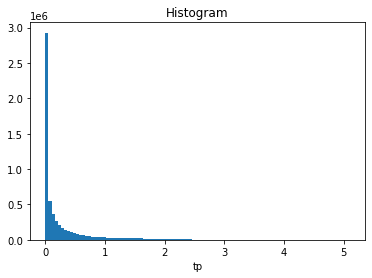

In [110]:
log_trans(tp, 0.001).plot.hist(bins=100);

In [113]:
xr.open_dataarray(f'{pred_save_dir}P/009-resnet_d3_tp_3d_cat.nc').bin_edges

array([      -inf, 0.02945295, 0.0589059 , 0.08835884, 0.11781179,
       0.14726474, 0.17671769, 0.20617064, 0.23562358, 0.26507653,
       0.29452948, 0.32398243, 0.35343537, 0.38288832, 0.41234127,
       0.44179422, 0.47124717, 0.50070011, 0.53015306, 0.55960601,
       0.58905896, 0.61851191, 0.64796485, 0.6774178 , 0.70687075,
       0.7363237 , 0.76577665, 0.79522959, 0.82468254, 0.85413549,
       0.88358844, 0.91304138, 0.94249433, 0.97194728, 1.00140023,
       1.03085318, 1.06030612, 1.08975907, 1.11921202, 1.14866497,
       1.17811792, 1.20757086, 1.23702381, 1.26647676, 1.29592971,
       1.32538266, 1.3548356 , 1.38428855, 1.4137415 , 1.44319445,
              inf])

Continue here: This should be 0 to 3. Check create predictions function!

### RMSE of mean

In [283]:
means = []
for v in preds_cat:
    means.append((preds_cat[v] * preds_cat[v].mid_points).sum('bin'))
means = xr.merge(means)

In [284]:
rmse_cat = compute_weighted_rmse(means, valid_diff).load()

In [285]:
rmse_cat

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 327.5
    t        float64 1.982
    t2m      float64 1.642
    tp       float64 0.01257

In [85]:
rmse_cat

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 370.2
    t        float64 1.982
    t2m      float64 1.642
    tp       float64 0.01257

In [86]:
rmse_cat.to_netcdf('tmp/rmse_cat.nc')

### Spread/skill ratio

In [88]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
meansquares = []
for v in preds_cat:
    meansquares.append((preds_cat[v] * preds_cat[v].mid_points**2).sum('bin'))
meansquares = xr.merge(meansquares)

In [89]:
var = meansquares - means**2

In [90]:
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()

In [91]:
spread = np.sqrt((var*weights_lat).mean())

In [93]:
spread_skill = spread / rmse_cat

In [94]:
spread_skill

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 0.8234
    t        float64 0.8818
    t2m      float64 0.8894
    tp       float64 1.606

In [95]:
spread_skill.to_netcdf('tmp/spread_skill_cat.nc')

### CRPS

In [286]:
crps = compute_weighted_bin_crps(preds_cat, valid_diff)

100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


In [287]:
crps

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 142.6
    t        float64 0.9533
    t2m      float64 0.7079
    tp       float64 0.05463

In [98]:
crps

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 163.1
    t        float64 0.9533
    t2m      float64 0.7079
    tp       float64 0.05463

In [99]:
crps.to_netcdf('tmp/crps_cat.nc')

### Rank histogram

### old

In [57]:
cat_zt_preds=xr.merge([cat_z_preds, cat_t_preds]).rename({'z':'z_500','t':'t_850'})
cat_zt_preds

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z_500    (time, lat, lon, bin) float32 ...
    t_850    (time, lat, lon, bin) float32 ...

In [43]:
cat_zt_preds.z_500 # a little different time-number from parametric, dropout
#from values it seems that this is 'predict_difference' method

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [          -inf -4811.67512001 -4611.18865667 -4410.70219334...
    mid_points:  [          -inf -4711.43188834 -4510.94542501 -4310.45896167...
    bin_width:   inf

In [44]:
cat_zt_preds.z_500.isel(time=0,lat=0,lon=0).values.sum() #probabilities outputted

1.000139

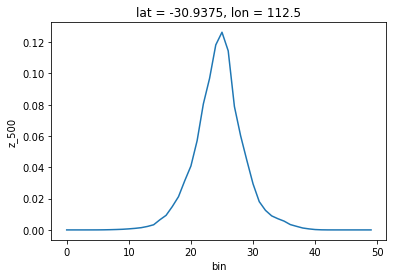

In [45]:
cat_zt_preds.z_500.isel(lat=10, lon=20).mean('time').plot()

In [94]:
#Valid data
zt_valid=xr.merge([z500_valid,t850_valid]).rename({'z':'z_500', 't':'t_850'})
zt_valid_diff = (zt_valid.shift() - zt_valid.shift(time=lead_time)).dropna('time')
zt_valid_diff #time size changes.

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17448)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>

In [59]:
#we should change -inf, inf to some finite values
cat_zt_preds.z_500.bin_edges[0]=zt_valid_diff.z_500.min().values
cat_zt_preds.z_500.bin_edges[-1]=zt_valid_diff.z_500.max().values
cat_zt_preds.t_850.bin_edges[0]=zt_valid_diff.t_850.min().values
cat_zt_preds.t_850.bin_edges[-1]=zt_valid_diff.t_850.min().values

cat_zt_preds.z_500.mid_points[0]=cat_zt_preds.z_500.bin_edges[1]-0.5*(cat_zt_preds.z_500.bin_edges[1]-cat_zt_preds.z_500.bin_edges[0])
cat_zt_preds.z_500.mid_points[-1]=cat_zt_preds.z_500.bin_edges[-2]+0.5*(cat_zt_preds.z_500.bin_edges[-1]-cat_zt_preds.z_500.bin_edges[-2])
cat_zt_preds.t_850.mid_points[0]=cat_zt_preds.t_850.bin_edges[1]-0.5*(cat_zt_preds.t_850.bin_edges[1]-cat_zt_preds.t_850.bin_edges[0])
cat_zt_preds.t_850.mid_points[-1]=cat_zt_preds.t_850.bin_edges[-2]+0.5*(cat_zt_preds.t_850.bin_edges[-1]-cat_zt_preds.t_850.bin_edges[-2])

#Ask- Unable to set bin-width as a  (50,1) array. doesnt matter. doesnt impact crps calculation.one solution is to take first and last bins as uniform and not min/max
#cat_zt_preds.z_500.bin_width=(cat_zt_preds.z_500.bin_edges[1:]-cat_zt_preds.z_500.bin_edges[:-1])

In [60]:
cat_zt_preds.z_500

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [-7296.640625   -4811.67512001 -4611.18865667 -4410.70219334...
    mid_points:  [-6054.1578725  -4711.43188834 -4510.94542501 -4310.45896167...
    bin_width:   inf

In [61]:
#For RMSE1- most likely class. But we lose all probability info.
# Using bin mid_points of prediction with highest probability
das = []
for var in ['z_500', 't_850']:
    idxs = np.argmax(cat_zt_preds[var], -1)
    most_likely = cat_zt_preds[var].mid_points[idxs]
    das.append(xr.DataArray(
        most_likely, dims=['time', 'lat', 'lon'],
        coords = [cat_zt_preds.time, cat_zt_preds.lat, cat_zt_preds.lon],
        name=var
    ))
preds_ml = xr.merge(das)
#preds_ml

In [62]:
preds_ml.z_500.mean().values, zt_valid_diff.z_500.mean().values

(array(15.22428736), array(-0.6240898, dtype=float32))

In [19]:
zt_cat_rmse=compute_weighted_rmse(preds_ml, zt_valid_diff.sel(time=preds_ml.time))
zt_cat_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 383.5
    t_850    float64 2.174

In [63]:
#Correct way. RMSE= ∑xP
aa=preds_ml.z_500.isel(time=0, lat=0,lon=0); print('most likely', aa.values)

ab=cat_zt_preds.z_500.isel(time=0, lat=0, lon=0);ab.values
ac=cat_zt_preds.z_500.mid_points; ac
ad=ab*ac; ad
print('mean',ad.sum().values)

most likely -100.24323166678825
mean -101.60616834764451


In [109]:
#Ask- Unable to run full. kernel dies.
ensemble_mean=xr.Dataset()
preds=cat_zt_preds.isel(time=slice(0,20))
z_500_ensemble=(preds.z_500*preds.z_500.mid_points).sum('bin')
t_850_ensemble=(preds.t_850*preds.t_850.mid_points).sum('bin')

ensemble_mean['z_500']=z_500_ensemble
ensemble_mean['t_850']=t_850_ensemble
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -101.6 -105.7 -102.0 ... -906.8 -903.0
    t_850    (time, lat, lon) float64 0.3607 0.2566 0.2119 ... -3.17 -3.029

In [110]:
zt_cat_rmse=compute_weighted_rmse(ensemble_mean, 
                                 zt_valid_diff.sel(
                                     time=ensemble_mean.time)).load()
zt_cat_rmse

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 410.3
    t_850    float64 2.009

In [111]:
compute_weighted_rmse(preds_ml.isel(time=slice(0,20)),zt_valid_diff.isel(time=slice(0,20))).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 447.3
    t_850    float64 2.186

In [112]:
#Correct RMSE= ∑xP
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -101.6 -105.7 -102.0 ... -906.8 -903.0
    t_850    (time, lat, lon) float64 0.3607 0.2566 0.2119 ... -3.17 -3.029

In [113]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
preds=cat_zt_preds.isel(time=slice(0,20))
obs=zt_valid_diff.sel(time=preds.time)
predssquare=preds
predssquare.z_500.attrs['mid_points']=preds.z_500.attrs['mid_points']*preds.z_500.attrs['mid_points']
predssquare.t_850.attrs['mid_points']=preds.t_850.attrs['mid_points']*preds.t_850.attrs['mid_points']

#predssquare.z_500

#Ask- Unable to run full. kernel dies.
ensemble_meansquare=xr.Dataset()
z_500_ensemble=(predssquare.z_500*predssquare.z_500.mid_points).sum('bin')
t_850_ensemble=(predssquare.t_850*predssquare.t_850.mid_points).sum('bin')

ensemble_meansquare['z_500']=z_500_ensemble
ensemble_meansquare['t_850']=t_850_ensemble
#ensemble_meansquare

#Spread
var1=ensemble_meansquare-ensemble_mean*ensemble_mean
weights_lat = np.cos(np.deg2rad(var1.lat))
weights_lat /= weights_lat.mean()
zt_cat_spread= np.sqrt((var1*weights_lat).mean())
zt_cat_spread

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 314.0
    t_850    float64 1.759

In [114]:
#Spread-skill
z_cat_spreadskill=zt_cat_spread/zt_cat_rmse
z_cat_spreadskill.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 0.7653
    t_850    float64 0.8752

In [37]:
# # Bin CRPS
obs=zt_valid_diff.sel(time=cat_zt_preds.time)
preds=cat_zt_preds
zt_cat_bin_crps=compute_weighted_bin_crps(preds, obs)
zt_cat_bin_crps.load()

100%|██████████| 175/175 [01:15<00:00,  2.33it/s]


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 162.9
    t_850    float64 0.9445

In [100]:
#Rank Histogram
member=20
preds=cat_zt_preds.isel(time=slice(0,20))
obs=zt_valid_diff.sel(time=preds.time)

z_bin_mids=preds.z_500.mid_points
t_bin_mids=preds.t_850.mid_points
preds_z=np.asarray(preds.z_500).reshape(-1,50)
preds_t=np.asarray(preds.t_850).reshape(-1,50)

preds_znew=[]
preds_tnew=[]
for i, p in enumerate(preds_z):
    prob_z=preds_z[i,:]; prob_t=preds_t[i,:]
    prob_z /= prob_z.sum();prob_t /= prob_t.sum()  #normalizing. bcoz sometimes prob doesn't equal exactly 1.
    sample_z=np.random.choice(z_bin_mids, size=member, p=preds_z[i,:],replace=True)
    sample_t=np.random.choice(t_bin_mids, size=member, p=preds_t[i,:],replace=True)
    preds_znew.append(sample_z)
    preds_tnew.append(sample_t)
    
preds_znew=np.array(preds_znew).reshape(member, -1)
preds_tnew=np.array(preds_tnew).reshape(member, -1)

In [101]:
#Rank Histogram
from ranky import rankz
obs_z=obs.z_500.values.reshape(-1)
obs_t=obs.t_850.values.reshape(-1)
# obs_t2m=obs.t2m.values.reshape(-1)
# obs_p=obs.tp.values.reshape(-1)


#for z_500
mask=np.ones(obs_z.shape) #useless. #masked where 0/false.
result_z = rankz(obs_z, preds_znew, mask)
result_t = rankz(obs_t, preds_tnew, mask)
# result_t2m = rankz(obs_z, preds_znew, mask)
# result_tp = rankz(obs_z, preds_znew, mask)

<BarContainer object of 21 artists>

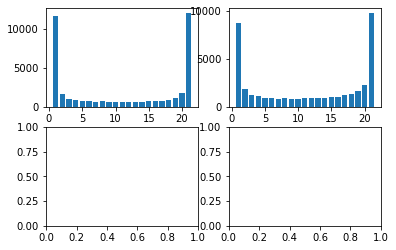

In [102]:
fig, axs=plt.subplots(2,2)
axs[0,0].bar(range(1,preds_znew.shape[0]+2), result_z[0])
axs[0,1].bar(range(1,preds_tnew.shape[0]+2), result_t[0])
#axs[1,0].bar(range(1,pred.t2m.values.shape[0]+2), result_t2m[0])
#axs[1,1].bar(range(1,pred.tp.values.shape[0]+2), result_tp[0])


In [103]:
#For RMSE3 -via sampling
shape_obs=obs.z_500.values.shape
preds_znew=preds_znew.reshape(shape_obs[0],shape_obs[1], shape_obs[2],member)
preds_tnew=preds_tnew.reshape(shape_obs[0],shape_obs[1], shape_obs[2],member)

In [104]:
preds_znew.shape

(20, 32, 64, 20)

In [105]:
preds_new=xr.Dataset()
z_500=xr.DataArray(preds_znew, dims=['time', 'lat', 'lon','member'],
        coords = {'time': preds.time, 'lat': preds.lat, 'lon': preds.lon,
                'member':np.arange(member)},)
t_850=xr.DataArray(preds_tnew, dims=['time', 'lat', 'lon','member'],
        coords = {'time': preds.time, 'lat': preds.lat, 'lon': preds.lon,
                'member':np.arange(member)},)


preds_new['z_500']=z_500
preds_new['t_850']=t_850
preds_new

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 20, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    z_500    (time, lat, lon, member) float64 -100.2 100.2 ... -701.7 -1.303e+03
    t_850    (time, lat, lon, member) float64 -2.369 -0.4738 ... 0.4738 -0.4738

In [106]:
#RMSE
zt_cat_rmse=compute_weighted_rmse(preds_new, zt_valid_diff.sel(time=preds_new.time))
zt_cat_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 516.9
    t_850    float64 2.671

In [107]:
zt_cat_spread=compute_weighted_meanspread(preds_new)
zt_cat_spreadskill=zt_cat_spread/zt_cat_rmse
zt_cat_spreadskill.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 0.5914
    t_850    float64 0.6424

In [108]:
zt_cat_crps=compute_weighted_crps(preds_new, zt_valid_diff.sel(time=preds_new.time))
zt_cat_crps.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 195.8
    t_850    float64 1.055

## Quantile-bins categorical

In [302]:
!ls {pred_save_dir}P

001-resnet_d3_ztt_3d_dr0.0_m50.nc  010-resnet_d3_z_3d_cat_quant.nc
001-resnet_d3_ztt_3d_dr0.0.nc	   011-resnet_d3_t_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m50.nc  012-resnet_d3_t2m_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2.nc	   017-resnet_d3_ztt_3d_m50.nc
004-resnet_d3_ztt_3d_dr0.5_m50.nc  020-resnet_d3_tp_3d_dr0.0_m50.nc
004-resnet_d3_ztt_3d_dr0.5_m5.nc   020-resnet_d3_tp_3d_dr0.0.nc
004-resnet_d3_ztt_3d_dr0.5.nc	   021-resnet_d3_tp_3d_dr0.2_m50.nc
005.1-resnet_d3_ztt_3d_param.nc    021-resnet_d3_tp_3d_dr0.2.nc
005-resnet_d3_ztt_3d_param.nc	   022-resnet_d3_tp_3d_dr0.5_m50.nc
006.1-resnet_d3_z_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5_m5.nc
006-resnet_d3_z_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5.nc
0078resnet_d3_t2m_3d_cat.nc	   054-resnet_d3_tp_3d_m50.nc
007-resnet_d3_t_3d_cat.nc	   saved_models
009-resnet_d3_tp_3d_cat.nc


In [306]:
preds_cat_quant = xr.merge([
    xr.open_dataset(f'{pred_save_dir}P/010-resnet_d3_z_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}P/011-resnet_d3_t_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}P/012-resnet_d3_t2m_3d_cat_quant.nc'),
#     xr.open_dataset(f'{pred_save_dir}P/009-resnet_d3_tp_3d_cat.nc'),
]).isel(time=slice(0, None, 12))

In [309]:
preds_cat_quant

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 1453)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z        (time, lat, lon, bin) float32 ...
    t        (time, lat, lon, bin) float32 ...
    t2m      (time, lat, lon, bin) float32 ...

In [312]:
preds_cat_quant.z.mid_points

array([          -inf, -2262.90819448, -1905.94275062, -1658.69273963,
       -1447.47462874, -1267.35939278, -1108.52931242,  -957.88672279,
        -828.527322  ,  -720.45703522,  -627.12695533,  -548.5331986 ,
        -479.75976529,  -419.16797222,  -363.49805428,  -316.01953567,
        -273.44922447,  -232.52305109,  -196.49961179,  -167.01562922,
        -140.8144552 ,  -116.25390622,   -93.33203109,   -73.68359191,
         -55.67187381,   -37.66015572,   -21.2851556 ,    -4.91015587,
          13.09960947,    32.74609317,    54.03320153,    80.23242123,
         111.34375074,   149.00586077,   194.85546774,   248.89257789,
         309.47461186,   373.33398728,   440.46874986,   512.50975308,
         592.73825947,   682.79687328,   794.14452641,   928.41562   ,
        1080.69689281,  1257.53750094,  1468.7640664 ,  1730.74216008,
        2109.47751819,            inf])

In [311]:
preds_cat.z.bin_edges

array([          -inf, -4811.67512001, -4611.18865667, -4410.70219334,
       -4210.21573001, -4009.72926667, -3809.24280334, -3608.75634   ,
       -3408.26987667, -3207.78341334, -3007.29695   , -2806.81048667,
       -2606.32402334, -2405.83756   , -2205.35109667, -2004.86463334,
       -1804.37817   , -1603.89170667, -1403.40524334, -1202.91878   ,
       -1002.43231667,  -801.94585333,  -601.45939   ,  -400.97292667,
        -200.48646333,     0.        ,   200.48646333,   400.97292667,
         601.45939   ,   801.94585333,  1002.43231667,  1202.91878   ,
        1403.40524334,  1603.89170667,  1804.37817   ,  2004.86463334,
        2205.35109667,  2405.83756   ,  2606.32402334,  2806.81048667,
        3007.29695   ,  3207.78341334,  3408.26987667,  3608.75634   ,
        3809.24280334,  4009.72926667,  4210.21573001,  4410.70219334,
        4611.18865667,  4811.67512001,            inf])

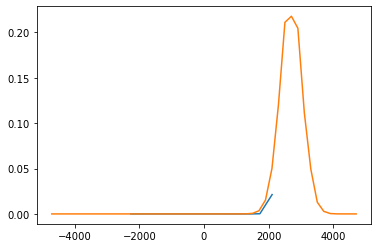

In [317]:
plt.plot(preds_cat_quant.z.mid_points, preds_cat_quant.z.sel(time=time).isel(lat=8, lon=0))
plt.plot(preds_cat.z.mid_points, preds_cat.z.sel(time=time).isel(lat=8, lon=0))

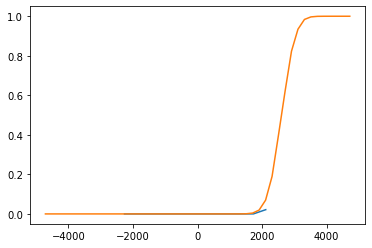

In [316]:
plt.plot(preds_cat_quant.z.mid_points, np.cumsum(preds_cat_quant.z.sel(time=time).isel(lat=8, lon=0)))
plt.plot(preds_cat.z.mid_points, np.cumsum(preds_cat.z.sel(time=time).isel(lat=8, lon=0)))

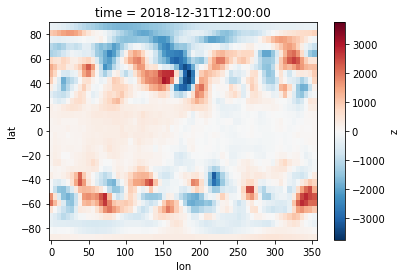

In [321]:
valid_diff.z.isel(time=-1).plot()

AttributeError: 'Dataset' object has no attribute 'tp'

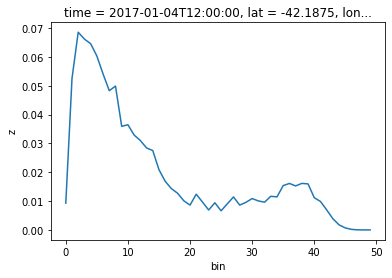

In [305]:
time = '2017-01-04T12:00:00'
preds_cat.z.sel(time=time).isel(lat=8, lon=16).plot()
preds_cat.tp.sel(time=time).isel(lat=8, lon=16).plot()

### Old

In [17]:
cat_zt_preds=xr.merge([cat_quant_z_preds, cat_quant_t_preds]).rename({'z':'z_500','t':'t_850'})
cat_zt_preds

<xarray.Dataset>
Dimensions:  (bin: 50, lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    z_500    (time, lat, lon, bin) float32 ...
    t_850    (time, lat, lon, bin) float32 ...

In [18]:
cat_zt_preds.z_500 # a little different time-number from parametric, dropout
#from values it seems that this is 'predict_difference' method

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [          -inf -2485.59762537 -2040.21876359 -1771.66673765...
    mid_points:  [          -inf -2262.90819448 -1905.94275062 -1658.69273963...
    bin_width:   inf

In [19]:
cat_zt_preds.z_500.isel(time=0,lat=0,lon=0).values.sum() #probabilities outputted

0.9999856

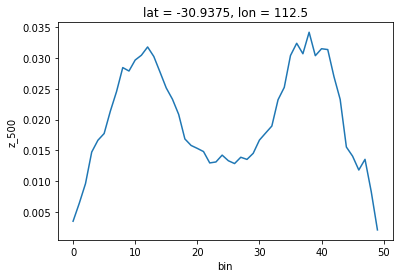

In [22]:
cat_zt_preds.z_500.isel(lat=10, lon=20).mean('time').plot() #bi-modal !!

In [23]:
#Valid data
zt_valid=xr.merge([z500_valid,t850_valid]).rename({'z':'z_500', 't':'t_850'})
zt_valid_diff = (zt_valid.shift() - zt_valid.shift(time=lead_time)).dropna('time')
zt_valid_diff #time size changes.

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17448)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float32 dask.array<chunksize=(8688, 32, 64), meta=np.ndarray>

In [24]:
#we should change -inf, inf to some finite values
cat_zt_preds.z_500.bin_edges[0]=zt_valid_diff.z_500.min().values
cat_zt_preds.z_500.bin_edges[-1]=zt_valid_diff.z_500.max().values
cat_zt_preds.t_850.bin_edges[0]=zt_valid_diff.t_850.min().values
cat_zt_preds.t_850.bin_edges[-1]=zt_valid_diff.t_850.min().values

cat_zt_preds.z_500.mid_points[0]=cat_zt_preds.z_500.bin_edges[1]-0.5*(cat_zt_preds.z_500.bin_edges[1]-cat_zt_preds.z_500.bin_edges[0])
cat_zt_preds.z_500.mid_points[-1]=cat_zt_preds.z_500.bin_edges[-2]+0.5*(cat_zt_preds.z_500.bin_edges[-1]-cat_zt_preds.z_500.bin_edges[-2])
cat_zt_preds.t_850.mid_points[0]=cat_zt_preds.t_850.bin_edges[1]-0.5*(cat_zt_preds.t_850.bin_edges[1]-cat_zt_preds.t_850.bin_edges[0])
cat_zt_preds.t_850.mid_points[-1]=cat_zt_preds.t_850.bin_edges[-2]+0.5*(cat_zt_preds.t_850.bin_edges[-1]-cat_zt_preds.t_850.bin_edges[-2])

#Ask- Unable to set bin-width as a  (50,1) array. doesnt matter. doesnt impact crps calculation.one solution is to take first and last bins as uniform and not min/max
#cat_zt_preds.z_500.bin_width=(cat_zt_preds.z_500.bin_edges[1:]-cat_zt_preds.z_500.bin_edges[:-1])

In [25]:
cat_zt_preds.z_500

<xarray.DataArray 'z_500' (time: 17436, lat: 32, lon: 64, bin: 50)>
[1785446400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * bin      (bin) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Attributes:
    bin_edges:   [-7.29664062e+03 -2.48559763e+03 -2.04021876e+03 -1.77166674...
    mid_points:  [-4.89111913e+03 -2.26290819e+03 -1.90594275e+03 -1.65869274...
    bin_width:   inf

In [26]:
#For RMSE1- most likely class. But we lose all probability info.
# Using bin mid_points of prediction with highest probability
das = []
for var in ['z_500', 't_850']:
    idxs = np.argmax(cat_zt_preds[var], -1)
    most_likely = cat_zt_preds[var].mid_points[idxs]
    das.append(xr.DataArray(
        most_likely, dims=['time', 'lat', 'lon'],
        coords = [cat_zt_preds.time, cat_zt_preds.lat, cat_zt_preds.lon],
        name=var
    ))
preds_ml = xr.merge(das)
preds_ml

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -548.5 -548.5 ... -1.447e+03 -1.447e+03
    t_850    (time, lat, lon) float64 -1.057 -1.731 -1.731 ... -6.546 -9.288

In [27]:
preds_ml.z_500.mean().values, zt_valid_diff.z_500.mean().values

(array(-154.42724882), array(-0.6240898, dtype=float32))

In [28]:
zt_cat_rmse=compute_weighted_rmse(preds_ml, zt_valid_diff.sel(time=preds_ml.time))
zt_cat_rmse.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 619.2
    t_850    float64 4.586

In [29]:
#Correct way. RMSE= ∑xP
aa=preds_ml.z_500.isel(time=0, lat=0,lon=0); print(aa.values)

ab=cat_zt_preds.z_500.isel(time=0, lat=0, lon=0);ab.values
ac=cat_zt_preds.z_500.mid_points; ac
ad=ab*ac; ad
ad.sum().values

-548.5331986033314


array(-467.04123775)

In [31]:
#Ask- Unable to run full. kernel dies.
preds=cat_zt_preds.isel(time=slice(0,20))
ensemble_mean=xr.Dataset()

z_500_ensemble=(preds.z_500*preds.z_500.mid_points).sum('bin')
t_850_ensemble=(preds.t_850*preds.t_850.mid_points).sum('bin')

ensemble_mean['z_500']=z_500_ensemble
ensemble_mean['t_850']=t_850_ensemble
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -467.0 -508.0 ... -1.654e+03 -1.645e+03
    t_850    (time, lat, lon) float64 -0.281 -0.5851 -0.8576 ... -1.554 -1.21

In [32]:
zt_cat_rmse=compute_weighted_rmse(ensemble_mean, 
                                 zt_valid_diff.sel(
                                     time=ensemble_mean.time)).load()
zt_cat_rmse

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 454.4
    t_850    float64 2.962

In [33]:
compute_weighted_rmse(preds_ml.isel(time=slice(0,20)),zt_valid_diff.isel(time=slice(0,20))).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 586.6
    t_850    float64 3.974

In [46]:
#Correct RMSE= ∑xP
ensemble_mean

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2017-01-05T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 -101.6 -105.7 -102.0 ... -906.8 -903.0
    t_850    (time, lat, lon) float64 0.3607 0.2566 0.2119 ... -3.17 -3.029

In [34]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
preds=cat_zt_preds.isel(time=slice(0,20))


obs=zt_valid_diff.sel(time=preds.time)
predssquare=preds
predssquare.z_500.attrs['mid_points']=preds.z_500.attrs['mid_points']*preds.z_500.attrs['mid_points']
predssquare.t_850.attrs['mid_points']=preds.t_850.attrs['mid_points']*preds.t_850.attrs['mid_points']

In [35]:
#predssquare.z_500

In [36]:
#Ask- Unable to run full. kernel dies.
ensemble_meansquare=xr.Dataset()
z_500_ensemble=(predssquare.z_500*predssquare.z_500.mid_points).sum('bin')
t_850_ensemble=(predssquare.t_850*predssquare.t_850.mid_points).sum('bin')

ensemble_meansquare['z_500']=z_500_ensemble
ensemble_meansquare['t_850']=t_850_ensemble
#ensemble_meansquare

In [37]:
#Spread
var1=ensemble_meansquare-ensemble_mean*ensemble_mean #Wrong. has -ve t values
weights_lat = np.cos(np.deg2rad(var1.lat))
weights_lat /= weights_lat.mean()
zt_cat_spread= np.sqrt((var1*weights_lat).mean())
zt_cat_spread

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 487.9
    t_850    float64 2.529

In [38]:
#Spread-skill
z_cat_spreadskill=zt_cat_spread/zt_cat_rmse
z_cat_spreadskill.load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 1.074
    t_850    float64 0.8541

In [39]:
# # Bin CRPS
obs=zt_valid_diff.sel(time=cat_zt_preds.time)
preds=cat_zt_preds
zt_cat_bin_crps=compute_weighted_bin_crps(preds, obs)
zt_cat_bin_crps.load() #WRONG. Can't be negative.

100%|██████████| 175/175 [01:55<00:00,  1.52it/s]


<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 188.3
    t_850    float64 -0.01537

In [40]:
#Rank Histogram
member=20
preds=cat_zt_preds.isel(time=slice(0,20))
obs=zt_valid_diff.sel(time=preds.time)

z_bin_mids=preds.z_500.mid_points
t_bin_mids=preds.t_850.mid_points
preds_z=np.asarray(preds.z_500).reshape(-1,50)
preds_t=np.asarray(preds.t_850).reshape(-1,50)

preds_znew=[]
preds_tnew=[]
for i, p in enumerate(preds_z):
    prob_z=preds_z[i,:]; prob_t=preds_t[i,:]
    prob_z /= prob_z.sum();prob_t /= prob_t.sum()  #normalizing. bcoz sometimes prob doesn't equal exactly 1.
    sample_z=np.random.choice(z_bin_mids, size=member, p=preds_z[i,:],replace=True)
    sample_t=np.random.choice(t_bin_mids, size=member, p=preds_t[i,:],replace=True)
    preds_znew.append(sample_z)
    preds_tnew.append(sample_t)
    
preds_znew=np.array(preds_znew).reshape(member, -1)
preds_tnew=np.array(preds_tnew).reshape(member, -1)

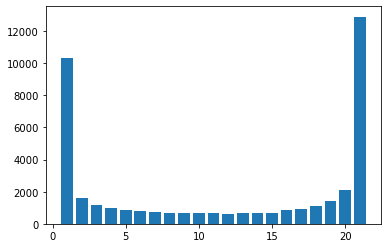

In [41]:
#Rank Histogram
from ranky import rankz
obs_z=obs.z_500.values.reshape(-1)
#for z_500
mask=np.ones(obs_z.shape) #useless. #masked where 0/false.
result = rankz(obs_z, preds_znew, mask)
plt.bar(range(1,preds_znew.shape[0]+2), result[0])
plt.show()

In [27]:
#for all

# create dropout ensemble testing

In [8]:
!ls {pred_save_dir}

001-resnet_d3_ztt_3d_dr0.0.nc	  010-resnet_d3_z_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2.nc	  011-resnet_d3_t_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m2.nc  020-resnet_d3_tp_3d_dr0.0.nc
004-resnet_d3_ztt_3d_dr0.5.nc	  021-resnet_d3_tp_3d_dr0.2.nc
004-resnet_d3_ztt_3d_dr0.5_m2.nc  021-resnet_d3_tp_3d_dr0.2_m2.nc
005-resnet_d3_ztt_3d_param.nc	  022-resnet_d3_tp_3d_dr0.5.nc
006-resnet_d3_z_3d_cat.nc	  saved_models
007-resnet_d3_t_3d_cat.nc


In [9]:
import tqdm
from tqdm import tqdm
#Somehow .py script doesn't run, but copying code here in notebook works.
#works for ztt, not for tp

In [10]:
    exp_id_path='/home/garg/WeatherBench/nn_configs/P/022-resnet_d3_tp_3d_dr0.5.yml'
    ensemble_size=2; old_const=False; no_mean=False; multi_dt=False; verbose=0
    no_mean=True; #for precipitation
    args=load_args(exp_id_path)
    args['model_save_dir']=model_save_dir
    args['pred_save_dir']=pred_save_dir
    args['datadir']=datadir

    args['ext_mean'] =xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
    args['ext_std'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')
    dg=load_data(**args, old_const=old_const, only_test=True)

    #tf.compat.v1.disable_eager_execution() #needed
    
    model = keras.models.load_model(
    f'{args["model_save_dir"]}/{args["exp_id"]}.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 
                   'lat_mse': tf.keras.losses.mse})
    #adding dropout
    c = model.get_config()
    for l in c['layers']:
        if l['class_name'] == 'Dropout':
            l['inbound_nodes'][0][0][-1] = {'training': True}
    
    model2 = keras.models.Model.from_config(c, custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 'lat_mse': tf.keras.losses.mse})
    model2.set_weights(model.get_weights())
            
    
    level_names = dg.data.isel(level=dg.output_idxs).level_names
    level = dg.data.isel(level=dg.output_idxs).level
    
    preds = []
    for _ in tqdm(range(ensemble_size)):
        #preds.append(model2.predict(dg.tfr_dataset or dg, verbose=verbose))
        preds.append(model2.predict(dg, verbose=verbose))
    

    
    preds = np.array(preds)
    

    preds = xr.DataArray(
        preds[0] if multi_dt else preds,
        dims=['member','time', 'lat', 'lon', 'level'],
        coords={'member':np.arange(ensemble_size),'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
                'level': level,
                'level_names': level_names
                },
    )
    # Unnormalize
    mean = dg.mean.isel(level=dg.output_idxs).values if not no_mean else 0
    std = dg.std.isel(level=dg.output_idxs).values
    preds = preds * std + mean
    #print(mean)
    unique_vars = list(set([l.split('_')[0] for l in preds.level_names.values]))

    # Reverse tranforms
    if hasattr(dg.mean, 'tp_log') and 'tp' in unique_vars:
        tp_idx = list(preds.level_names).index('tp')
        preds.values[..., tp_idx] = log_retrans(preds.values[..., tp_idx], dg.mean.tp_log)

    das = []
    for v in unique_vars:
        idxs = [i for i, vv in enumerate(preds.level_names.values) if vv.split('_')[0] == v]
        da = preds.isel(level=idxs).squeeze().drop('level_names')
        if not 'level' in da.dims: da = da.drop('level')
        das.append({v: da})
    preds=xr.merge(das)
    
    preds.to_netcdf(f'{args["pred_save_dir"]}/{args["exp_id"]}_m{ensemble_size}.nc')
    print(f'saved on disk in {args["pred_save_dir"]}/{args["exp_id"]}_m{ensemble_size}.nc')


  0%|          | 0/2 [00:00<?, ?it/s]


StopIteration: 

In [13]:
exp_id='004-resnet_d3_ztt_3d_dr0.5_2'
preds1=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [14]:
preds1

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 2, time: 17436)
Coordinates:
  * member   (member) int64 0 1
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (member, time, lat, lon) float64 ...
    z        (member, time, lat, lon) float64 ...
    t        (member, time, lat, lon) float64 ...

# Plots

In [ ]:
t2m_valid.t2m.isel(lat=10, lon =30).plot()